<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/S%C3%A9ries%20temporelles/Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

# Chargement des données

On télécharge un script depuis Github permettant de télécharger un fichier stocké sur GoogleDrive, puis on utilise ce script écrit en Python pour télécharger le fichier `bitcoin.zip`. Enfin, on décompresse les données pour obtenir le fichier `bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv` :

In [2]:
# Récupération des données au format .csv

!git clone https://github.com/chentinghao/download_google_drive.git
!python download_google_drive/download_gdrive.py "1FZsEdpBm-AQ2L9n_pMnm6336-O_IVo7z" "/content/bitcoin.zip"
!unzip bitcoin.zip

Cloning into 'download_google_drive'...
remote: Enumerating objects: 16, done.
remote: Total 16 (delta 0), reused 0 (delta 0), pack-reused 16
Unpacking objects: 100% (16/16), done.
100MB [00:00, 114MB/s]  
Archive:  bitcoin.zip
  inflating: bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv  


Charge la série sous Pandas et affiche les informations du fichier :

In [3]:
# Création de la série sous Pandas
serie = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


# Pré-traitement des données

**1. Recherche des erreurs dans les données**

On commence par vérifier qu'il ne manque pas de dates. Pour cela, on vérifie qu'il y a bien 60 secondes entre deux Timestamp. Si on trouve un décalage non cohérent, on enregistre les informations dans une liste.

In [4]:
# Fonction permettant de vérifier si chaque intervalle est bien de 60s
def recherche_erreur(fenetre):
  if fenetre.values[1] - fenetre.values[0] != 60:
    Timestamp_Errors.append(fenetre.values)
  return 0

# Définit une liste pour sauvegarder le résultat des recherches
Timestamp_Errors = []

# Applique la fonction sur une fenêtre glissante des données
serie.Timestamp.rolling(2).apply(recherche_erreur)

KeyboardInterrupt: ignored

On affiche les erreurs trouvées :

In [5]:
# Affiche les informations sur les erreurs trouvées

for erreur in Timestamp_Errors:
  print (pd.to_datetime(Timestamp_Errors[0],unit="s"))
  print((Timestamp_Errors[0][1] - Timestamp_Errors[0][0])/60 - 1)

On observe qu'il manque des données entre le 5 janvier 2015 à 9:12:00 et le 9 janvier 2015 à 21:05:00, soit 6472 données.

Recherchons maintenant le nombre de données manquantes :

In [4]:
# Affichage du nombre total de données manquantes

data_manquantes = sum(np.isnan(serie['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)

Nombre de données manquantes : 1243608


On a donc en tout : 6472 + 1243608 = 1250080 données manquantes.

**2. Identification des erreurs**

On convertit maintenant les `Timestamp` (mesure de temps exprimé en seconde écoulé depuis le 01/01/1970 - 00:00:00 UTC) en format plus standard :

In [4]:
# Conversion des timestamp en date
serie.Timestamp = pd.to_datetime(serie['Timestamp'], unit="s")
serie

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4857372,2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
4857373,2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
4857374,2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
4857375,2021-03-30 23:59:00,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


On demande maintenant à échantillonner les données sur 60 secondes :

In [5]:
# Echantillonnage de la série sur 1min
serie_minute = serie.set_index('Timestamp').resample('60s').asfreq()

# Récupère le nombre de données sans valeurs numériques
data_manquantes = sum(np.isnan(serie_minute['Open']))

# Affiche le nombre de données manquantes et la série sur 1min 
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 1250080


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-12-31 07:56:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


On obtient en tout 4863849 données après échantillonnage, soit (4863849-4857377) =  6472 données supplémentaires. Ceci est cohérent avec ce qu'on avait trouvé avant. Il manque 1250080 données. 

**3. Correction des données**

Pour corriger les données, on va tout simplement utiliser la fonction [fillna](https://pandas.pydata.org/docs/reference/api/pandas.Series.fillna.html) de Pandas avec la fonctionnalité de type `backfill` :

In [6]:
# Applique la fonction de remplissage automatique des données non numérique avec l'option backfill

serie_minute = serie_minute.fillna(method="backfill")

In [7]:
# Récupère le nombre de données non numériques et affiche les informations

data_manquantes = sum(np.isnan(serie_minute['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_minute

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31 07:52:00,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
2011-12-31 07:53:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:54:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:55:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2011-12-31 07:56:00,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
...,...,...,...,...,...,...,...
2021-03-30 23:56:00,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
2021-03-30 23:57:00,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
2021-03-30 23:58:00,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496


**4. Affichage des données**

Text(0.5, 1.0, 'Evolution du prix du BTC')

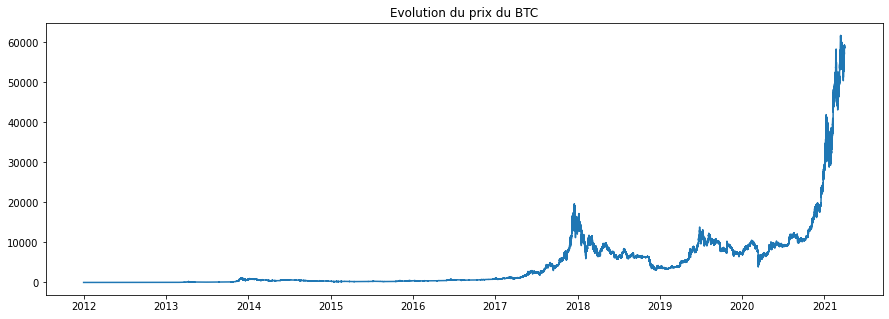

In [8]:
# Récupère les prix à l'ouverture et les index au format date
prix_ouverture = np.asarray(serie_minute.Open)
dates_ouverture = np.asarray(serie_minute.index)

# Affiche la série
plt.figure(figsize=(15,5))
plt.plot(dates_ouverture, prix_ouverture)
plt.title("Evolution du prix du BTC")

# Préparation des données pour les prédictions

Nous allons réaliser des modélisations sur la série journalière, et pour une période allant du 1er avril 2013 au 31 mars 2021.

**1. Création de la série journalière**

On va réaliser des prédictions à l'aide d'une série à fréquence journalière. On commence par tenter d'estimer les données manquantes à l'aide d'une interpolation linéaire à l'aide de la fonction [interpolate](https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html#pandas.Series.interpolate) de Pandas, puis on complète avec la méthode `backfill` si nécessaire.

In [9]:
# Echantillonne la série sur 1 jour
serie_jour = serie.set_index('Timestamp').resample('1D').asfreq()

# Remplissage des données non numériques par interpolation linéraire
serie_jour = serie_jour.interpolate(method="slinear")

# Remplissage des données non numériques restantes par backfill
serie_jour = serie_jour.fillna(method="backfill")

# Affiche les informations
data_manquantes = sum(np.isnan(serie_jour['Open']))
print ("Nombre de données manquantes : %s" %data_manquantes)
serie_jour

Nombre de données manquantes : 0


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2011-12-31,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-01,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-02,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-03,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
2012-01-04,4.93,4.93,4.93,4.93,6.110463,30.124582,4.930000
...,...,...,...,...,...,...,...
2021-03-27,55081.26,55300.00,55081.26,55261.73,8.781130,484506.899450,55175.914921
2021-03-28,55817.85,55920.82,55807.12,55920.82,0.770004,43011.953916,55859.414172
2021-03-29,55790.28,55822.98,55777.98,55804.36,1.731449,96636.546983,55812.518695


Sauvegarde de l'évolution du prix sur l'intervalle d'étude dans un vecteur de type numpy :

In [10]:
# Définition des dates de début et de fin

date_debut = "2013-04-01 00:00:00"
date_fin = "2021-03-31 00:00:00"

# Sauvegarde du prix et des dates lors de l'ouverture des marchés dans un array numpy
prix_ouverture = serie_jour.loc[date_debut:date_fin].Open
dates_ouverture = serie_jour.loc[date_debut:date_fin].index

**2. Détection des anomalies dans la série "jour"**

Les anomalies sont fréquentes dans les séries temporelles, et la performance des prédictions est souvent améliorée lorsque ces anomalies sont traitées.  
Pour avoir un apperçu de ces éventuelles anomalies, nous allons utiliser la méthode ["Isolation Forest"](https://scikit-learn.org/stable/modules/outlier_detection.html#isolation-forest) disponnible dans Scikit-learn.  

Les paramètres utilisés sont les suivants :
 - **n_estimators** : C'est le nombre de sous-groupes d'échantillons à utiliser. Une valeur de 128 ou 256 est préconnisée dans le document de recherche.
 - **max_samples** : C'est le nombre d'échantillons maximum à utiliser. Nous utiliserons l'ensemble des échantillons.
 - **max_features** :  C'est le nombre de motifs aléatoirement choisis sur chaque noeud de l'arbre. Nous choisirons un seul motif.
 - **contamination** : C'est le pourcentage estimé d'anomalies dans les données. Ce paramètre permet de régler la sensibilité de l'algorithme. On va commencer avec 5% et affiner si nécessaire par la suite.

In [15]:
# Initialise le modèle
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=256,max_samples=len(prix_ouverture), contamination=0.05,max_features=1, verbose=1)
clf.fit(np.reshape(np.asarray(prix_ouverture,dtype=np.float32),newshape=(-1,1)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.05,
                max_features=1, max_samples=2922, n_estimators=256, n_jobs=None,
                random_state=None, verbose=1, warm_start=False)

In [16]:
# Réalise les prédictions
pred = clf.predict(np.reshape(np.asarray(prix_ouverture,dtype=np.float32),newshape=(-1,1)))
pred

array([ 1,  1,  1, ..., -1, -1, -1])

On ajoute maintenant ces informations dans la série journalière et on affiche les informations :

In [17]:
# Ajoute une colonne "Anomalie" dans la série
serie_jour.loc[date_debut:date_fin,'Anomalies']=pred
serie_jour['Anomalies'] = serie_jour['Anomalies'].apply(lambda x: 1 if (x==-1) else 0)
serie_jour.loc[date_debut:date_fin]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Anomalies
Timestamp,,,,,,,,
2013-04-01,99.525714,99.525714,99.525714,99.525714,0.155256,11.900373,99.525714,0
2013-04-02,103.730000,103.730000,103.730000,103.730000,0.014465,1.500435,103.730000,0
2013-04-03,116.000000,116.000000,116.000000,116.000000,31.713233,3678.735005,116.000000,0
2013-04-04,133.870000,134.540000,133.870000,134.540000,1.100634,147.497941,134.011742,0
2013-04-05,134.670000,134.670000,134.670000,134.670000,4.704580,633.565789,134.670000,0
...,...,...,...,...,...,...,...,...
2021-03-27,55081.260000,55300.000000,55081.260000,55261.730000,8.781130,484506.899450,55175.914921,1
2021-03-28,55817.850000,55920.820000,55807.120000,55920.820000,0.770004,43011.953916,55859.414172,1
2021-03-29,55790.280000,55822.980000,55777.980000,55804.360000,1.731449,96636.546983,55812.518695,1


In [18]:
# Affiche les informations sur les anomalies
print(serie_jour.loc[date_debut:date_fin]['Anomalies'].value_counts())

0    2775
1     147
Name: Anomalies, dtype: int64


**3. Affichage des anomalies sur le graphique**

In [19]:
# Récupère une tableau numpy comprenant les anomalies
anomalies = np.asarray(serie_jour.loc[date_debut:date_fin].Anomalies)

# Affiche la série

fig = px.line(x=dates_ouverture,y=prix_ouverture,title="Evolution du prix du BTC")
fig.add_trace(px.scatter(x=dates_ouverture,y=anomalies*prix_ouverture,color=anomalies.astype(np.bool)).data[0])

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

Comme les anomalies détectées ne sembles pas cohérentes, nous n'allons pas les traiter...

# Analyse de la série temporelle

In [11]:
# Définition des dates de début et de fin

date_debut_pacf = "2013-01-01 00:00:00"
date_fin_pacf = "2021-03-31 00:00:00"

# Sauvegarde du prix et des dates lors de l'ouverture des marchés dans un array numpy
prix_ouverture_pacf = np.asarray(serie_jour.loc[date_debut:date_fin].Open)

Text(0.5, 1.0, 'Autocorrélation partielle')

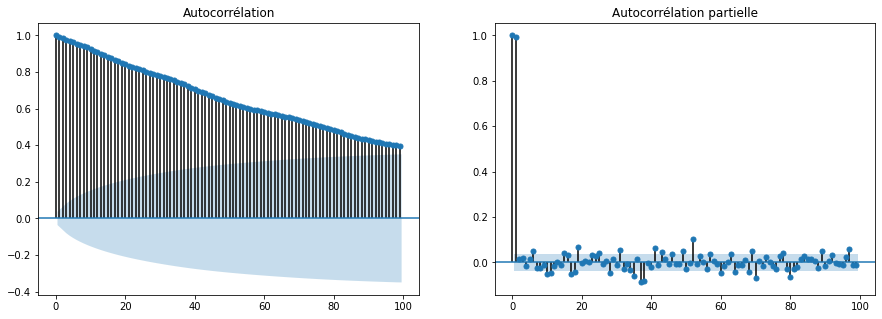

In [14]:
# ACF & PACF

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
f1.subplots_adjust(hspace=0.3,wspace=0.2)

plot_acf(prix_ouverture_pacf, ax=ax1, lags = range(0,100))
ax1.set_title("Autocorrélation")

plot_pacf(prix_ouverture_pacf, ax=ax2, lags = range(0, 100))
ax2.set_title("Autocorrélation partielle")


In [202]:
from statsmodels.tsa.stattools import pacf

pacf = pacf(prix_ouverture_pacf, nlags=100)

In [203]:
T = len(prix_ouverture_pacf)

sig_test = lambda tau_h: np.abs(tau_h) > 2.58/np.sqrt(T)

for i in range(len(pacf)):
    if sig_test(pacf[i]) == False:
        n_steps = i - 1
        print('n_steps set to', n_steps)
        break

n_steps set to 1


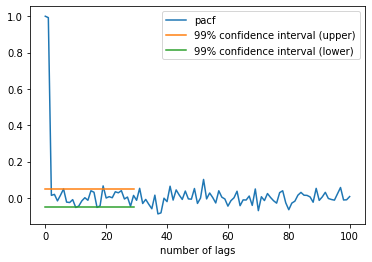

In [204]:
plt.plot(pacf, label='pacf')
plt.plot([2.58/np.sqrt(T)]*30, label='99% confidence interval (upper)')
plt.plot([-2.58/np.sqrt(T)]*30, label='99% confidence interval (lower)')
plt.xlabel('number of lags')
plt.legend();

# Préparation des données X et Y

In [12]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# au format X(X1,X2,...Xn) / Y(Y1,Y2,...,Yn)
# X sont les données d'entrées du réseau
# Y sont les labels

def prepare_dataset_XY(serie, taille_fenetre, batch_size, buffer_melange):
  dataset = tf.data.Dataset.from_tensor_slices(serie)
  dataset = dataset.window(taille_fenetre+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(taille_fenetre + 1))
  dataset = dataset.map(lambda x: (x[:-1], x[-1:]))
  dataset = dataset.batch(batch_size,drop_remainder=True).prefetch(1)
  return dataset

**1. Séparation des données en données pour l'entrainement et la validation**

On réserve 20% des données pour l'entrainement et le reste pour la validation :


In [13]:
temps_separation = int(0.8*len(prix_ouverture))

# Création de la base de temps
temps_ouverture = np.linspace(0,len(prix_ouverture)-1,len(prix_ouverture)).astype(np.int)

# Extraction des temps et des données d'entrainement
temps_entrainement = temps_ouverture[:temps_separation]
x_entrainement = prix_ouverture[:temps_separation]

# Exctraction des temps et des données de valiadation
temps_validation = temps_ouverture[temps_separation:]
x_validation = prix_ouverture[temps_separation:]

print("Taille de l'entrainement : %d" %len(x_entrainement))
print("Taille de la validation : %d" %len(x_validation))

Taille de l'entrainement : 2337
Taille de la validation : 585


In [74]:
x_entrainement

Timestamp
2013-04-01       99.525714
2013-04-02      103.730000
2013-04-03      116.000000
2013-04-04      133.870000
2013-04-05      134.670000
                  ...     
2019-08-20    10927.300000
2019-08-21    10778.750000
2019-08-22    10123.560000
2019-08-23    10112.450000
2019-08-24    10401.870000
Freq: D, Name: Open, Length: 2337, dtype: float64

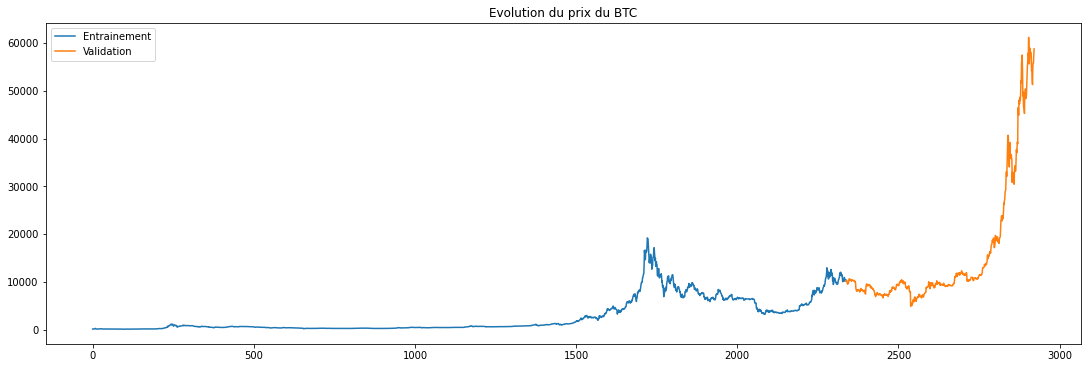

In [14]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))
ax.plot(temps_entrainement, x_entrainement, label="Entrainement")
ax.plot(temps_validation, x_validation,label="Validation")

ax.set_title("Evolution du prix du BTC")

ax.legend()
plt.show()

**2. Préparation des données X et des labels Y**

In [76]:
x_entrainement

Timestamp
2013-04-01       99.525714
2013-04-02      103.730000
2013-04-03      116.000000
2013-04-04      133.870000
2013-04-05      134.670000
                  ...     
2019-08-20    10927.300000
2019-08-21    10778.750000
2019-08-22    10123.560000
2019-08-23    10112.450000
2019-08-24    10401.870000
Freq: D, Name: Open, Length: 2337, dtype: float64

In [57]:
# Définition des caractéristiques du dataset que l'on souhaite créer
taille_fenetre = 5
batch_size = 128
buffer_melange = 5000

# Calcul de la moyenne et de l'écart type de la série
mean = tf.math.reduce_mean(np.asarray(x_entrainement))
std = tf.math.reduce_std(np.asarray(x_entrainement))

# Normalise les données
Serie_Normalisee = (prix_ouverture-mean)/std

# Création des données pour l'entrainement et le test
x_entrainement_norm = Serie_Normalisee[:temps_separation]
x_validation_norm = Serie_Normalisee[temps_separation:]

# Création du dataset X,Y
dataset = prepare_dataset_XY(x_entrainement,taille_fenetre,batch_size,buffer_melange)
dataset_norm = prepare_dataset_XY(x_entrainement_norm,taille_fenetre,batch_size,buffer_melange)

# Création du dataset X,Y de validation
dataset_Val_norm = prepare_dataset_XY(x_validation_norm,taille_fenetre,batch_size,buffer_melange)

In [48]:
dataset_Val_norm

<PrefetchDataset shapes: ((512, None), (512, None)), types: (tf.float64, tf.float64)>

In [80]:
for element in dataset.take(1).as_numpy_iterator():
  print(element)

(array([[ 99.52571429, 103.73      , 116.        , 133.87      ,
        134.67      ],
       [103.73      , 116.        , 133.87      , 134.67      ,
        137.835     ],
       [116.        , 133.87      , 134.67      , 137.835     ,
        141.        ],
       [133.87      , 134.67      , 137.835     , 141.        ,
        170.31333333],
       [134.67      , 137.835     , 141.        , 170.31333333,
        199.62666667],
       [137.835     , 141.        , 170.31333333, 199.62666667,
        228.94      ],
       [141.        , 170.31333333, 199.62666667, 228.94      ,
        162.        ],
       [170.31333333, 199.62666667, 228.94      , 162.        ,
        135.95      ],
       [199.62666667, 228.94      , 162.        , 135.95      ,
        109.9       ],
       [228.94      , 162.        , 135.95      , 109.9       ,
         90.44      ],
       [162.        , 135.95      , 109.9       ,  90.44      ,
         91.79      ],
       [135.95      , 109.9       ,  90.44

# Création du modèle GRU

**1. Création du réseau et adaptation des formats d'entrée et de sortie**

Par défaut, la dimension des vecteurs cachés est de 40 et aucune régularisation n'est utilisée.

In [49]:
# Classe d'auto-attention
# Applique les poids de la matrice d'attention sur les vecteurs de la couche récurrente

# Importe le Backend de Keras
from keras import backend as K

# Définit une nouvelle classe Couche_Attention
# Héritée de la classe Layer de Keras

class Couche_Auto_Attention(tf.keras.layers.Layer):
  # Fonction d'initialisation de la classe d'attention
  def __init__(self,dim_att,nbr_hop):
    self.dim_att = dim_att          # Dimension du vecteur d'attention
    self.nbr_hop = nbr_hop
    super().__init__()              # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = self.add_weight(shape=(self.dim_att,input_shape[2]),initializer='glorot_uniform',name="W")
    self.U = self.add_weight(shape=(self.nbr_hop,self.dim_att),initializer='glorot_uniform',name="U")
    super().build(input_shape)        # Appel de la méthode build()

  # Définit la logique de la couche d'attention
  # Arguments :   x : Tenseur d'entrée de dimension (None, nbr_v,dim)
  def call(self,x):
    # Calcul de la matrice XH contenant les
    # représentations cachées des vecteurs
    # issus de la couche GRU
    xt = tf.transpose(x,perm=[0,2,1])           # (None,20,40) => (None,40,20)
    Xh = tf.matmul(self.W,xt)                   # (#Att,40)x(None,40,20) = (None,#Att,20)
    Xh = K.tanh(Xh)                             # Xh = (None,#Att,20)

    # Calcul de la matrice des poids d'attention normalisés
    A = tf.matmul(self.U,Xh)                    # (#hop,#Att)x(None,#Att,20) = (None,#Att,20)
    A = tf.keras.activations.softmax(A,axis=2)  # (None,#Att,20)

    # Calcul de la matrice des vecteur d'attentions
    sortie = tf.matmul(A,x)                     # (None,#Att,20)x(None,20,40) = (None,#Att,40)
    return tf.keras.layers.Flatten()(sortie)

In [17]:
def ModelGRU(dim_GRU = 40, l1_reg=0, l2_reg=0):

  dim_GRU = 40
  nbr_hop = 2

  # Fonction de la couche lambda d'entrée
  def Traitement_Entrees(x):
    return tf.expand_dims(x,axis=-1)

  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fenetre))

  # Encodeur
  e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
  s_encodeur = tf.keras.layers.LSTM(dim_GRU,return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(1e-5))(e_adapt)
  s_attention = Couche_Auto_Attention(dim_att=dim_GRU,nbr_hop=nbr_hop)(s_encodeur)

  # Décodeur
  s_decodeur = tf.keras.layers.Dense(dim_GRU*nbr_hop,activation="tanh")(s_attention)
  s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_attention])

  # Générateur
  sortie = tf.keras.layers.Dense(1)(s_decodeur)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(), metrics="mae")
  
  return(model)

In [126]:
def ModelGRU(dim_GRU = 40, l1_reg=0, l2_reg=0):

  # Fonction de la couche lambda d'entrée
  def Traitement_Entrees(x):
    return tf.expand_dims(x,axis=-1)

  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fenetre))

  # Encodeur
  e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
  s_encodeur = tf.keras.layers.LSTM(dim_GRU, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(e_adapt)

  # Décodeur
  s_decodeur = tf.keras.layers.Dense(dim_GRU,activation="tanh",kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)
  s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_encodeur])

  # Générateur
  sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_decodeur)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(), metrics="mae")

  return(model)

In [20]:
def ModelGRU(dim_GRU = 40, l1_reg=0, l2_reg=0):

  # Fonction de la couche lambda d'entrée
  def Traitement_Entrees(x):
    return tf.expand_dims(x,axis=-1)

  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fenetre))

  # Encodeur
  e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
  s_encodeur = tf.keras.layers.LSTM(dim_GRU, kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(e_adapt)
  
  # Générateur
  sortie = tf.keras.layers.Dense(1,kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg,l2=l2_reg))(s_encodeur)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)
  model.compile(loss=tf.keras.losses.Huber(), optimizer=tf.keras.optimizers.SGD(), metrics="mae")

  return(model)

On définit le nombre maximal de périodes pour l'entrainement, ainsi que la fonction d'arrêt automatique de l'entrainement avec la fonction [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) de Keras.

In [43]:
max_periodes = 1000
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=1e-7, restore_best_weights=True)

**2. Un premier essai**

In [19]:
model = ModelGRU()

In [58]:
  dim_GRU = 40
  nbr_hop = 2

  # Fonction de la couche lambda d'entrée
  def Traitement_Entrees(x):
    return tf.expand_dims(x,axis=-1)

  # Définition de l'entrée du modèle
  entrees = tf.keras.layers.Input(shape=(taille_fenetre))

  # Encodeur
  e_adapt = tf.keras.layers.Lambda(Traitement_Entrees)(entrees)
  s_encodeur = tf.keras.layers.LSTM(dim_GRU,return_sequences=True,recurrent_regularizer=tf.keras.regularizers.l2(1e-5))(e_adapt)
  s_attention = Couche_Auto_Attention(dim_att=dim_GRU,nbr_hop=nbr_hop)(s_encodeur)

  # Décodeur
  s_decodeur = tf.keras.layers.Dense(dim_GRU*nbr_hop,activation="tanh")(s_attention)
  s_decodeur = tf.keras.layers.Concatenate()([s_decodeur,s_attention])

  # Générateur
  sortie = tf.keras.layers.Dense(1)(s_decodeur)

  # Construction du modèle
  model = tf.keras.Model(entrees,sortie)


In [59]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(lr=1e-8)

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur, metrics="mae")

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
historique = model.fit(dataset_norm,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

Epoch 1/100
18/18 [==============================] - 2s 11ms/step - loss: 0.2659 - mae: 0.6980

Epoch 00001: loss improved from inf to 0.38348, saving model to poids.hdf5
Epoch 2/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2658 - mae: 0.6980

Epoch 00002: loss improved from 0.38348 to 0.38348, saving model to poids.hdf5
Epoch 3/100
18/18 [==============================] - 0s 15ms/step - loss: 0.2658 - mae: 0.6980

Epoch 00003: loss improved from 0.38348 to 0.38348, saving model to poids.hdf5
Epoch 4/100
18/18 [==============================] - 0s 17ms/step - loss: 0.2658 - mae: 0.6980

Epoch 00004: loss improved from 0.38348 to 0.38348, saving model to poids.hdf5
Epoch 5/100
18/18 [==============================] - 0s 16ms/step - loss: 0.2658 - mae: 0.6980

Epoch 00005: loss improved from 0.38348 to 0.38348, saving model to poids.hdf5
Epoch 6/100
18/18 [==============================] - 0s 16ms/step - loss: 0.2658 - mae: 0.6980

Epoch 00006: loss improved from 0

Text(0.5, 1.0, "Evolution de l'erreur en fonction du taux d'apprentissage")

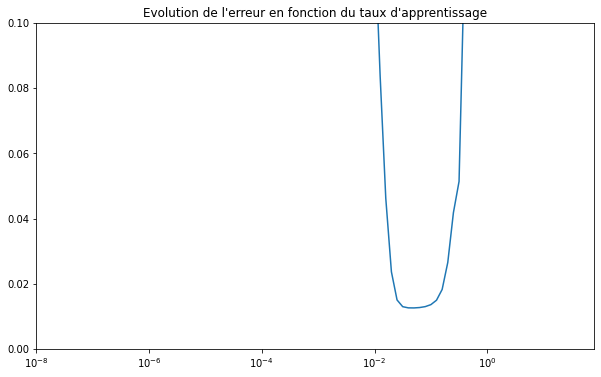

In [60]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[0], taux[99], 0, 0.1])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [64]:
# Chargement des poids sauvegardés
model.load_weights("poids.hdf5")

In [65]:
# Classe permettant d'arrêter l'entrainement si la variation
# devient plus petite qu'une valeur à choisir sur un nombre
# de périodes à choisir
class StopTrain(keras.callbacks.Callback):
    def __init__(self, delta=0.01,periodes=100, term="loss", logs={}):
      self.n_periodes = 0
      self.periodes = periodes
      self.loss_1 = 100
      self.delta = delta
      self.term = term
    def on_epoch_end(self, epoch, logs={}):
      diff_loss = abs(self.loss_1 - logs[self.term])
      self.loss_1 = logs[self.term]
      if (diff_loss < self.delta):
        self.n_periodes = self.n_periodes + 1
      else:
        self.n_periodes = 0
      if (self.n_periodes == self.periodes):
        print("Arrêt de l'entrainement...")
        self.model.stop_training = True

# Définition des paramètres liés à l'évolution du taux d'apprentissage
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.02,
    decay_steps=10,
    decay_rate=0.001)

# Définition de l'optimiseur à utiliser
optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)
#optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Utilisation de la méthode ModelCheckPoint
CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

# Compile le modèle
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimiseur,metrics="mae")

# Entraine le modèle
historique = model.fit(dataset_norm,validation_data=dataset_Val_norm, epochs=1000,verbose=1, callbacks=[CheckPoint,StopTrain(delta=1e-5,periodes = 20, term="val_loss")])


Epoch 1/1000
18/18 [==============================] - 3s 48ms/step - loss: 0.0043 - mae: 0.0424 - val_loss: 0.3281 - val_mae: 0.4947

Epoch 00001: loss improved from inf to 0.01162, saving model to poids_train.hdf5
Epoch 2/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0060 - mae: 0.0725 - val_loss: 0.3009 - val_mae: 0.4704

Epoch 00002: loss did not improve from 0.01162
Epoch 3/1000
18/18 [==============================] - 0s 26ms/step - loss: 0.0033 - mae: 0.0384 - val_loss: 0.2915 - val_mae: 0.4478

Epoch 00003: loss improved from 0.01162 to 0.00887, saving model to poids_train.hdf5
Epoch 4/1000
18/18 [==============================] - 0s 25ms/step - loss: 0.0043 - mae: 0.0323 - val_loss: 0.2559 - val_mae: 0.4689

Epoch 00004: loss did not improve from 0.00887
Epoch 5/1000
18/18 [==============================] - 0s 23ms/step - loss: 0.0049 - mae: 0.0534 - val_loss: 0.3474 - val_mae: 0.6268

Epoch 00005: loss did not improve from 0.00887
Epoch 6/1000
18/18 [===

Text(0.5, 1.0, "Evolution de l'erreur en fonction de la période")

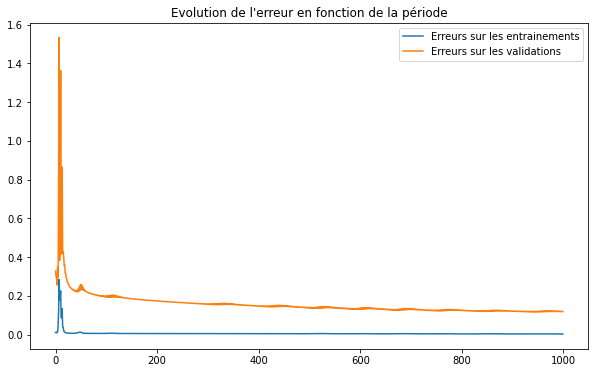

In [66]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [67]:
# Horizon des prédictions
horizon = 1

predictions = []
dates_predictions = []
couleurs = []

serie = np.asarray(prix_ouverture)

for t in range(0,570,horizon):
      dates_X = dates_ouverture[temps_separation-taille_fenetre+t:temps_separation]
      dates_Y = dates_ouverture[temps_separation:temps_separation+t]

      dates_predictions.append(dates_ouverture[temps_separation+t])

      X = np.asarray(serie[temps_separation-taille_fenetre+t:temps_separation])
      Y = np.asarray(serie[temps_separation:temps_separation+t])
      Z = np.concatenate((X,Y))[-taille_fenetre:]
      Z = (Z-mean)/std

      dates = np.concatenate((dates_X,dates_Y))[-taille_fenetre:]

      pred = model.predict(np.reshape(Z,(1,taille_fenetre)))
      predictions.append(pred[0,0])

      for j in range(1,horizon):
        dates_predictions.append(dates_ouverture[temps_separation+t+j])

        pred = np.reshape(predictions,(1,len(predictions)))[0,:]*std+mean
        Z = np.concatenate((X,pred))[-taille_fenetre:]
        Z = (Z-mean)/std
        pred = model.predict(np.reshape(Z,(1,taille_fenetre)))
        predictions.append(pred[0,0])


In [88]:
# Horizon des prédictions
horizon = 1

predictions_ent = []
dates_predictions_ent = []

serie = np.asarray(prix_ouverture)

for t in range(taille_fenetre,temps_separation,horizon):
      dates_X = dates_ouverture[-taille_fenetre+t:]
      dates_Y = dates_ouverture[:+t]

      dates_predictions_ent.append(dates_ouverture[+t])

      X = np.asarray(serie[-taille_fenetre+t:])
      Y = np.asarray(serie[:+t])
      Z = np.concatenate((X,Y))[-taille_fenetre:]
      Z = (Z-mean)/std

      dates = np.concatenate((dates_X,dates_Y))[-taille_fenetre:]

      pred = model.predict(np.reshape(Z,(1,taille_fenetre)))
      predictions_ent.append(pred[0,0])

      for j in range(1,horizon):
        dates_predictions_ent.append(dates_ouverture[+t+j])

        pred = np.reshape(predictions_ent,(1,len(predictions_ent)))[0,:]*std+mean
        Z = np.concatenate((X,pred))[-taille_fenetre:]
        Z = (Z-mean)/std
        pred = model.predict(np.reshape(Z,(1,taille_fenetre)))
        predictions_ent.append(pred[0,0])

In [89]:
import plotly.graph_objects as go

pred = np.reshape(predictions,(1,len(predictions)))[0,:]*std+mean
pred_ent = np.reshape(predictions_ent,(1,len(predictions_ent)))[0,:]*std+mean

fig = go.Figure()
fig.add_trace(go.Scatter(x=dates_ouverture,y=prix_ouverture,line=dict(color='blue', width=1),name="Prix BTC"))
fig.add_trace(go.Scatter(x=dates_predictions,y=pred,line=dict(color='red', width=1),name="Prédictions"))
fig.add_trace(go.Scatter(x=dates_predictions_ent,y=pred_ent,line=dict(color='green', width=1),name="Entrainement"))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()